In [1]:
import numpy as np

import torch
import torch.nn as nn

import torchvision.transforms as T

from model import TimeShiftModel

from time_shift_dataset import TimeShiftDataset

In [2]:
model: TimeShiftModel = torch.load('./models/model_time_shift_PRX_30_N.pth')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
_ = model.to(device)

cuda


In [4]:
dataset = TimeShiftDataset('../datasets/hand', transform=T.Compose([
    T.Resize(128),
    T.ToTensor(),
    T.Grayscale()
]), proximity=1, train=False)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    # drop_last=True,
    num_workers=1,
)

In [5]:
embeddings = []

model.eval()
for image, _, _, _ in dataloader:
    image = image.to(device)
    emb = model(image).cpu().detach().flatten()

    embeddings.append(np.array(emb))

In [6]:
len(embeddings)

525

In [7]:
embeddings = np.array(embeddings)

## PCA

In [8]:
# from sklearn.decomposition import PCA

In [9]:
# mean_emb = embeddings.mean(axis=0)
# std_emb = embeddings.std(axis=0) 
# emb_norm = (embeddings - mean_emb) / std_emb

In [10]:
# emb_norm.mean(), emb_norm.std()

In [11]:
# pca = PCA(n_components=2, svd_solver='full')
# pca.fit(emb_norm)

# embeddings_red = pca.transform(emb_norm)
# X, Y = embeddings_red[:,0], embeddings_red[:,1]

In [12]:
import matplotlib.pyplot as plt

In [13]:
# plt.scatter(X, Y)

In [14]:
# X_sorted = sorted(list(zip(X, range(len(X)))), key= lambda x: x[0])

## Nearest Neighbours

In [15]:
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import ImageGrid

In [16]:
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(embeddings)

NearestNeighbors(n_neighbors=10)

In [17]:
random_index = np.random.randint(len(embeddings))
neigh.kneighbors(embeddings[random_index].reshape(1,-1), 10, return_distance=False)

array([[351, 350, 349, 348, 353, 352, 355, 347, 354, 366]])

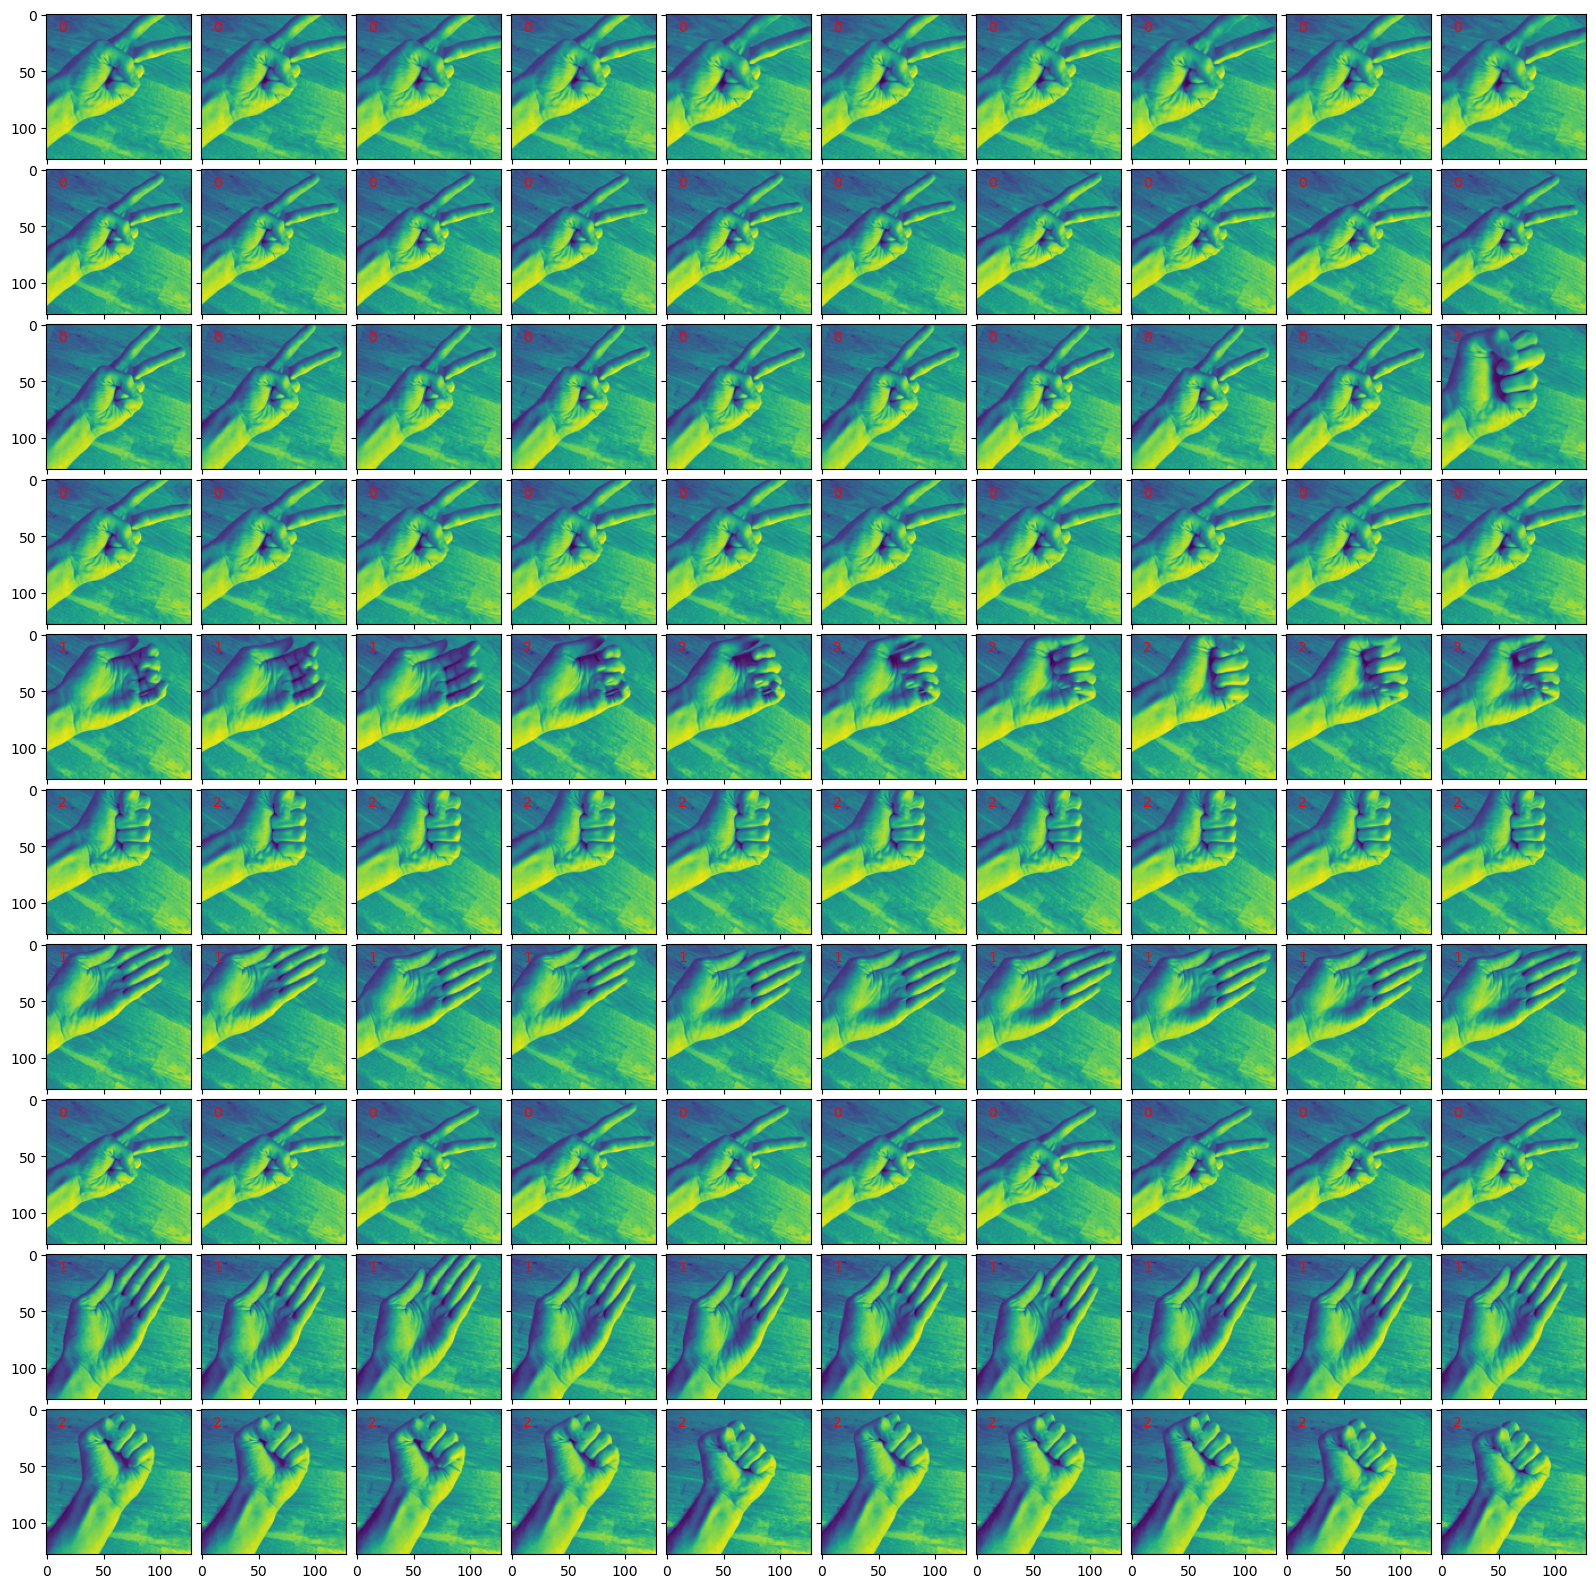

In [18]:
num_samples = 10
num_neighb = 10

fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(10,num_neighb), axes_pad=0.1)

for r in range(num_samples):
    random_index = np.random.randint(len(embeddings))
    neighb_index = neigh.kneighbors(embeddings[random_index].reshape(1,-1), num_neighb, return_distance=False)

    for c in range(len(neighb_index[0])):
        im, _, cls, _ = dataset.__getitem__(neighb_index[0][c])
        im = im.swapaxes(0,-1).swapaxes(0,1)
        ax: plt.Axes = grid[num_neighb*r+c]
        ax.text(10.0, 15.0, cls, {'color': 'red'})
        ax.imshow(im, )

In [19]:
# fig = plt.figure(figsize=(200,200))
# grid = ImageGrid(fig, 111, nrows_ncols=(100, 5), axes_pad=0.1)

# for ax, (_, i) in zip(grid, X_sorted):
#     im, _ = dataset.__getitem__(i)
#     im = im.swapaxes(0,-1).swapaxes(0,1)
#     ax.imshow(im)